#FULL CODE: Working with Yelp Review Text using NLTK

In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
## Read in review data
## To get the full dataset, use the below: 

rvws = pd.read_csv("data\yelp_academic_dataset_review.csv") 

## Below csv was created previously using the first 5,000 reviews. Once this is a working model we can expand it to a fuller dataset.
# reviews = pd.read_csv("data\yelp_academic_dataset_review.csv")
# rvws = reviews.iloc[:5000,:]
# rvws.to_csv("yelp_dataset_testing.csv")
# rvws = pd.read_csv("data\yelp_dataset_5k_review.csv")

In [15]:
## To make things easier when trying to analyze the text, let's just look at restaurants. For that, we'll have to join the review
## and business data. I'm also pulling the city and state so we can split this up by city, based on the assumption that
## language will vary depending on location.

headers = ['categories','business_id','city','state']
business = pd.read_csv("data\yelp_academic_dataset_business.csv", usecols = headers)
reviews_full = pd.merge(rvws, business, on = 'business_id')

In [20]:
reviews_full.describe()

,votes.cool,votes.funny,stars,votes.useful
count,1569264.000000,1569264.000000,1569264.000000,1569264.00000
mean,0.594182,0.478886,3.742656,1.07162
std,1.617808,1.538368,1.311468,2.05166
min,0.000000,0.000000,1.000000,0.00000
25%,0.000000,0.000000,3.000000,0.00000
50%,0.000000,0.000000,4.000000,0.00000
75%,1.000000,0.000000,5.000000,1.00000
max,137.000000,141.000000,5.000000,166.00000


In [21]:
## Now that we have the data joined with the business information, we can narrow the dataset to just restaurants so that
## the language we are looking for is more consistent. 
## (e.g. a good doctor review will have differnt language than a good restaurant review)

cat = reviews_full['categories']
rest = []

for x in range(len(cat)):
    if "Restaurants" in cat[x]:
        rest.append(1)
    elif "Food" in cat[x]:
        rest.append(1)
    else:
        rest.append(0)

reviews_full['restaurant'] = rest

## This will modify our reviews DataFrame to only include business that fall into the "restaurants" category,
## Then reset the index.

reviews_full = reviews_full[reviews_full['restaurant'] == 1]
reviews_full = reviews_full.reset_index(drop=True)

In [22]:
## In addition to narrowing it down to one city to work with. We will revisit the impact of location after doing as much
## as we can with just the text for all reviews in one city.

city = reviews_full['city']
city.value_counts()[:30]

Las Vegas          402889
Phoenix            156592
Scottsdale          85399
Charlotte           67038
Pittsburgh          50538
Tempe               47012
Henderson           32641
Chandler            30578
Madison             29697
Mesa                27842
Montréal            23631
Gilbert             19281
Glendale            16960
Edinburgh           13999
Montreal            12746
Peoria               8209
Champaign            6772
North Las Vegas      6458
Surprise             5283
Goodyear             4891
Avondale             3560
Queen Creek          3042
Cave Creek           2994
Urbana               2826
Matthews             2587
Middleton            1978
Karlsruhe            1710
Fort Mill            1656
Waterloo             1480
Concord              1333
dtype: int64

In [23]:
## To lower run time and make the featureset more consistent, limit to one city.

reviews = reviews_full[reviews_full['city'] == 'Avondale']
reviews = reviews.reset_index(drop=True)
reviews.to_csv("yelp_dataset_reviews_Avondale")
reviews.head()

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful,categories,state,city,restaurant
0,cTT7cTG6SuVOc1ib6gwhHA,uPez-RSvBOxO1AWTGMtB7g,3.5 Stars\n\nEvery clerk there is friendly. N...,2,j5qC_y7mRRWNUqFdR8Z1_A,1,3,2013-10-13,review,3,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1
1,kcgYbndUk0e07YusRAcTrg,Q6L6oNvb60GMqdN5xxSRiw,"Simple and small, haven't tried their water or...",0,j5qC_y7mRRWNUqFdR8Z1_A,0,3,2014-07-29,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1
2,vrIuFfhpUyOA_m9goXVWxw,yVV5W3cDRYow2nEPQDN-EQ,Ashley is really awesome she is always with a ...,0,j5qC_y7mRRWNUqFdR8Z1_A,1,5,2014-10-01,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1
3,l72Kt2u68aLuJVX9J8J0hQ,PLEltvCMh8u7FlxFf225og,Great old time ice cream shop from the '20s. R...,0,j5qC_y7mRRWNUqFdR8Z1_A,0,5,2014-10-04,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1
4,Iqw0kVKBtgo4Vn8AtG2kRA,BuwZ9XJgenH9mET_zCCbrA,This is a small family owned business so I'll ...,0,j5qC_y7mRRWNUqFdR8Z1_A,0,3,2014-11-16,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1


Value counts for each star so we can get a general sense of distribution:
5    1260
4    1097
3     488
1     393
2     322
dtype: int64


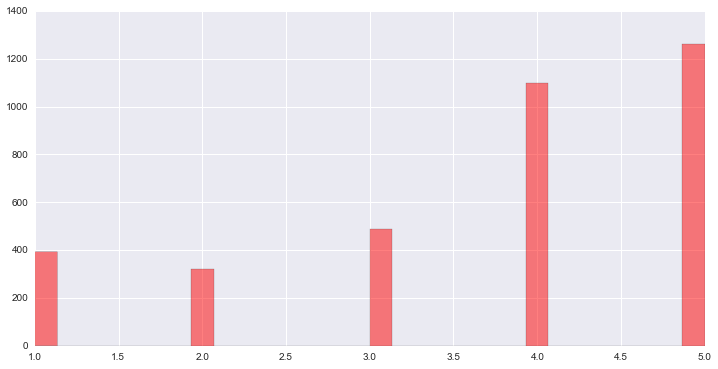

In [24]:
## Separate into features and target

text = reviews['text']
stars = reviews['stars']

print "Value counts for each star so we can get a general sense of distribution:"
print stars.value_counts()
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
stars.hist(color='red', alpha=0.5, bins = 30)

In [25]:
## Create features based on the text.
## First, append text_length to data frame which signifies the length of the review text.

text_length = []
for x in range(len(reviews['text'])):
    text_length.append(len(text[x]))

reviews['text_length'] = text_length
reviews.head()

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful,categories,state,city,restaurant,text_length
0,cTT7cTG6SuVOc1ib6gwhHA,uPez-RSvBOxO1AWTGMtB7g,3.5 Stars\n\nEvery clerk there is friendly. N...,2,j5qC_y7mRRWNUqFdR8Z1_A,1,3,2013-10-13,review,3,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1,616
1,kcgYbndUk0e07YusRAcTrg,Q6L6oNvb60GMqdN5xxSRiw,"Simple and small, haven't tried their water or...",0,j5qC_y7mRRWNUqFdR8Z1_A,0,3,2014-07-29,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1,722
2,vrIuFfhpUyOA_m9goXVWxw,yVV5W3cDRYow2nEPQDN-EQ,Ashley is really awesome she is always with a ...,0,j5qC_y7mRRWNUqFdR8Z1_A,1,5,2014-10-01,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1,196
3,l72Kt2u68aLuJVX9J8J0hQ,PLEltvCMh8u7FlxFf225og,Great old time ice cream shop from the '20s. R...,0,j5qC_y7mRRWNUqFdR8Z1_A,0,5,2014-10-04,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1,278
4,Iqw0kVKBtgo4Vn8AtG2kRA,BuwZ9XJgenH9mET_zCCbrA,This is a small family owned business so I'll ...,0,j5qC_y7mRRWNUqFdR8Z1_A,0,3,2014-11-16,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1,1167


In [26]:
## Download list of positive / negative from here: http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html
## Grab a generic words of positive and negative words; we are going to use these to get a sentiment score out of the text.

positives = open('data/positive-words.txt').read()
negatives = open('data/negative-words.txt').read()
pos_word_list = positives.split('\n')
neg_word_list = negatives.split('\n')
print "POSITIVE WORDS: {}".format(pos_word_list)
print "NEGATIVE WORDS: {}".format(neg_word_list)

POSITIVE WORDS: ['', '', 'a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation', 'accolade', 'accolades', 'accommodative', 'accomodative', 'accomplish', 'accomplished', 'accomplishment', 'accomplishments', 'accurate', 'accurately', 'achievable', 'achievement', 'achievements', 'achievible', 'acumen', 'adaptable', 'adaptive', 'adequate', 'adjustable', 'admirable', 'admirably', 'admiration', 'admire', 'admirer', 'admiring', 'admiringly', 'adorable', 'adore', 'adored', 'adorer', 'adoring', 'adoringly', 'adroit', 'adroitly', 'adulate', 'adulation', 'adulatory', 'advanced', 'advantage', 'advantageous', 'advantageously', 'advantages', 'adventuresome', 'adventurous', 'advocate', 'advocated', 'advocates', 'affability', 'affable', 'affably', 'affectation', 'affection', 'affectionate', 'affinity', 'affirm', 'affirmation', 'affirmative', 'affluence', 'affluent', 'afford', 'affordable', 'affordably', 'afordable', 'agile', 'agilely', 'ag

In [27]:
## Create function to output list of words in given list from a sentence.
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def review_to_wordlist(review, remove_stopwords=False):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.

    review_text = review   
    
    # 1. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)

    # 2. Convert words to lower case and split them
    words = review_text.lower().split()

    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    # 5. Return a list of words
    return(words)

def word_count(sentence, word_list):
    count = 0
    for x in review_to_wordlist(sentence):
        if x in word_list:
            count += 1
    
    return count

In [28]:
%%time

## Use positive and negative words to give each piece of a text a sentiment score. The sentiment score ranges from
## -1 (all negative words) to 1 (all positive words).

sentiment = []
pos_neg_ratio = []
count = 0

for x in text:
    positive = word_count(x, pos_word_list)
    negative = word_count(x, neg_word_list)
    if (negative > 0):
        ratio = float(positive)/negative
    else:
        ratio = positive
    
    if ((positive + negative) == 0):
        sent = 1
    else:
        sent = ((positive-negative)/(float(positive)+negative))+1
        
    sentiment.append(sent)
    pos_neg_ratio.append(ratio)
    if count % 1000 == 0:
        print "Scoring text #{}".format(count)
    count += 1

reviews['sentiment'] = sentiment
reviews['pos_neg_ratio'] = pos_neg_ratio

Scoring text #0
Scoring text #1000
Scoring text #2000
Scoring text #3000
Wall time: 28.3 s


In [29]:
## Features used for initial pass: text length, ratio of positive to negative words, and sentiment.

feature_list = ['text_length', 'pos_neg_ratio', 'sentiment']
features = reviews[feature_list]
stars = reviews['stars']

In [30]:
## Test using Various models. Set up the train test split first, then fit various models and see how they perform.

from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score

In [31]:
## Fit and score various models with cross validation

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = cross_validation.train_test_split(features, stars, test_size=0.3, random_state=12)
extra = ExtraTreesClassifier()
mnbayes = MultinomialNB()
svc = SVC(C=1, probability=True)
adaboost = AdaBoostClassifier()
logreg = LogisticRegression(C=1)

extra.fit(x_train, y_train)
mnbayes.fit(x_train, y_train)
svc.fit(x_train, y_train)
adaboost.fit(x_train, y_train)
logreg.fit(x_train, y_train)

print "Extra Trees score: {}".format(extra.score(x_test, y_test))
print "Multinomial Naive Bayes score: {}".format(mnbayes.score(x_test, y_test))
print "SVC Score: {}".format(svc.score(x_test, y_test))
print "Ada Boosted Decision Tree Score: {}".format(adaboost.score(x_test, y_test))
print "Logistic Regression Score: {}".format(logreg.score(x_test, y_test))

Extra Trees score: 0.348314606742
Multinomial Naive Bayes score: 0.424157303371
SVC Score: 0.34925093633
Ada Boosted Decision Tree Score: 0.420411985019
Logistic Regression Score: 0.453183520599


In [32]:
## Before trying to move on to a new method, let's make this a binary predictor by
## separating reviews into "good" (4-5 stars) and "bad" (1-3 stars)

# Playing with different star thresholds for what we consider a "good" or "bad" review.
star_threshold = 4

reviews['good'] = (reviews['stars'] >= star_threshold)
good = reviews['good']
good = good.map({True: 1, False: 0})

In [33]:
## Define a function to plot ROC curves

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(target_test, target_predicted_proba, this_label):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label= this_label + ', ROC Area = %0.3f' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('ROC')
    plt.legend(loc="lower right")

## Define a function to train & test 5 different classifiers, output scores and AUC

def test_classifiers(x_train, x_test, y_train, y_test, features, target):

    extra.fit(x_train, y_train)
    mnbayes.fit(x_train, y_train)
    svc.fit(x_train, y_train)
    adaboost.fit(x_train, y_train)
    logreg.fit(x_train, y_train)

    print "Extra Forest score: {}".format(extra.score(x_test, y_test))
    print "Multinomial Naive Bayes score: {}".format(mnbayes.score(x_test, y_test))
    print "SVC Score: {}".format(svc.score(x_test, y_test))
    print "Ada Boosted Decision Tree Score: {}".format(adaboost.score(x_test, y_test))
    print "Logistic Regression Score: {}\n".format(logreg.score(x_test, y_test))

    print "Extra Forest AUC: {}".format(cross_val_score(extra, features, good, cv=3, scoring='roc_auc').mean())
    print "Multinomial Naive Bayes AUC: {}".format(cross_val_score(mnbayes, features, good, cv=3, scoring='roc_auc').mean())
    print "SVC AUC: {}".format(cross_val_score(svc, features, good, cv=3, scoring='roc_auc').mean())
    print "Ada Boosted Decision Tree AUC: {}".format(cross_val_score(adaboost, features, good, cv=3, scoring='roc_auc').mean())
    print "Logistic Regression AUC: {}".format(cross_val_score(logreg, features, good, cv=3, scoring='roc_auc').mean())

    plot_roc_curve(y_test, extra.predict_proba(x_test), "Extra Trees")
    plot_roc_curve(y_test, mnbayes.predict_proba(x_test), "MN Bayes")
    plot_roc_curve(y_test, svc.predict_proba(x_test), "SVM SVC")
    plot_roc_curve(y_test, adaboost.predict_proba(x_test), "Ada Boost")
    plot_roc_curve(y_test, logreg.predict_proba(x_test), "Logistic Regression")

Extra Forest score: 0.703183520599
Multinomial Naive Bayes score: 0.756554307116
SVC Score: 0.698501872659
Ada Boosted Decision Tree Score: 0.772471910112
Logistic Regression Score: 0.7734082397

Extra Forest AUC: 0.711010769996
Multinomial Naive Bayes AUC: 0.785258161787
SVC AUC: 0.694393418732
Ada Boosted Decision Tree AUC: 0.801001525025
Logistic Regression AUC: 0.812701576286


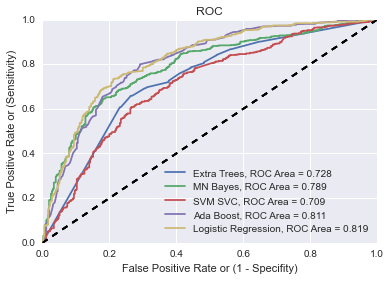

In [34]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(features, good, test_size=0.3, random_state=12)

test_classifiers(x_train, x_test, y_train, y_test, features, good)

In [41]:
from sklearn.metrics import confusion_matrix

print "Logistic Regression Confusion Matrix: \n", confusion_matrix(y_test, logreg.predict(x_test)), "\n"
print "Extra Trees Confusion Matrix: \n", confusion_matrix(y_test, extra.predict(x_test)), "\n" 
print "Ada Boosted Decision Tree Confusion Matrix: \n", confusion_matrix(y_test, adaboost.predict(x_test)), "\n"
print "SVC Confusion Matrix: \n", confusion_matrix(y_test, svc.predict(x_test)), "\n"
print "Multi-nomial Bayes Confusion Matrix: \n", confusion_matrix(y_test, mnbayes.predict(x_test)), "\n"

Logistic Regression Confusion Matrix: 
[[196 154]
 [ 88 630]] 

Extra Trees Confusion Matrix: 
[[207 143]
 [174 544]] 

Ada Boosted Decision Tree Confusion Matrix: 
[[188 162]
 [ 81 637]] 

SVC Confusion Matrix: 
[[105 245]
 [ 77 641]] 

Multi-nomial Bayes Confusion Matrix: 
[[206 144]
 [116 602]] 



#### Because the binary target was much easier to predict and for the sake of this exploratory exercise, we're going to only use the good/bad target

##Add a "service" and "stop list" score to see how closely that correlates to reviews
"Serivce" measures the positive & negative words around the word "service", as it exists in about 1/3rd of the reviews.
"stops" measures how many stop words are in a given review.

In [42]:
service = []
stops = []
stop_words = set(stopwords.words("english"))

for i in range(len(text)):
    x = review_to_wordlist(text[i])
    if 'service' in x:
        service_loc = x.index('service')
        near_service = x[int(service_loc-8):int(service_loc+8)]
        pos_service = word_count(' , '.join(near_service).strip(), pos_word_list)
        neg_service = word_count(' , '.join(near_service).strip(), neg_word_list)
        if pos_service > 0 or neg_service > 0:
            service.append((float((pos_service-neg_service))/(pos_service+neg_service))+1)
        else:
            service.append(1)
    else:
        service.append(1)
    stops.append(float(word_count(text[i], stop_words))/len(x))

reviews['service_sentiment'] = service
reviews['stop_word_ratio'] = stops
reviews.head()

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful,categories,state,city,restaurant,text_length,sentiment,pos_neg_ratio,good,service_sentiment,stop_word_ratio
0,cTT7cTG6SuVOc1ib6gwhHA,uPez-RSvBOxO1AWTGMtB7g,3.5 Stars\n\nEvery clerk there is friendly. N...,2,j5qC_y7mRRWNUqFdR8Z1_A,1,3,2013-10-13,review,3,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1,616,2.0,4.000000,False,2,0.450450
1,kcgYbndUk0e07YusRAcTrg,Q6L6oNvb60GMqdN5xxSRiw,"Simple and small, haven't tried their water or...",0,j5qC_y7mRRWNUqFdR8Z1_A,0,3,2014-07-29,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1,722,2.0,5.000000,False,1,0.479167
2,vrIuFfhpUyOA_m9goXVWxw,yVV5W3cDRYow2nEPQDN-EQ,Ashley is really awesome she is always with a ...,0,j5qC_y7mRRWNUqFdR8Z1_A,1,5,2014-10-01,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1,196,2.0,6.000000,True,2,0.540541
3,l72Kt2u68aLuJVX9J8J0hQ,PLEltvCMh8u7FlxFf225og,Great old time ice cream shop from the '20s. R...,0,j5qC_y7mRRWNUqFdR8Z1_A,0,5,2014-10-04,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1,278,1.5,3.000000,True,1,0.442308
4,Iqw0kVKBtgo4Vn8AtG2kRA,BuwZ9XJgenH9mET_zCCbrA,This is a small family owned business so I'll ...,0,j5qC_y7mRRWNUqFdR8Z1_A,0,3,2014-11-16,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1,1167,0.6,0.428571,False,1,0.538462


In [43]:
feature_list = ['text_length', 'pos_neg_ratio', 'sentiment', 'service_sentiment', 'stop_word_ratio']
features = reviews[feature_list]
stars = reviews['stars']
features.head()

,text_length,pos_neg_ratio,sentiment,service_sentiment,stop_word_ratio
0,616,4.000000,2.0,2,0.450450
1,722,5.000000,2.0,1,0.479167
2,196,6.000000,2.0,2,0.540541
3,278,3.000000,1.5,1,0.442308
4,1167,0.428571,0.6,1,0.538462


Extra Forest score: 0.730337078652
Multinomial Naive Bayes score: 0.75
SVC Score: 0.705992509363
Ada Boosted Decision Tree Score: 0.779026217228
Logistic Regression Score: 0.785580524345

Extra Forest AUC: 0.744425201266
Multinomial Naive Bayes AUC: 0.782158710639
SVC AUC: 0.698560250266
Ada Boosted Decision Tree AUC: 0.80095519374
Logistic Regression AUC: 0.821066650053


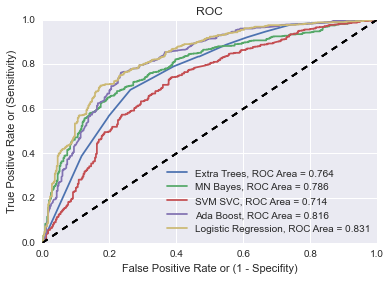

In [44]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(features, good, test_size=0.3, random_state=12)

test_classifiers(x_train, x_test, y_train, y_test, features, good)

## Create sentiment scores for common and uncommon words

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

vect = CountVectorizer(decode_error = 'ignore', stop_words = 'english', min_df=0.005)
vect.fit(text)
text_dtm = vect.transform(text)
text_array = text_dtm.toarray()

count_vocab = np.sum(text_array, axis=0)
text_freq = vect.get_feature_names()

vect_uncommon = CountVectorizer(decode_error = 'ignore', stop_words = 'english', max_df=0.995)
vect_uncommon.fit(text)
text_unfreq = vect_uncommon.get_feature_names()

vocab_freq_df = pd.DataFrame({'Frequency': count_vocab, 'Token': text_freq})
print "Words in feature set: {}".format(len(vect.get_feature_names()))
# print vocab_freq_df.sort(columns = 'Frequency', ascending = False)

print len(text_freq)
print len(text_unfreq)

Words in feature set: 1225
1225
10944


In [47]:
## Create new positive and negative word lsits that contain common or uncommon words in the feature set.
## Common words are in the top 99.5%; uncommon are the bottom 0.5%

freq_pos = [w for w in pos_word_list if w in text_freq]
freq_neg = [w for w in neg_word_list if w in text_freq]
unfreq_pos = [w for w in pos_word_list if w in text_unfreq]
unfreq_neg = [w for w in neg_word_list if w in text_unfreq]

C:\Users\samchu\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
C:\Users\samchu\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [48]:
%%time

## Create new positive and negative word lists that contain common or uncommon words in the feature set.

freq_sentiment = []
unfreq_sentiment = []
count = 0

for x in text:
    common_positive = word_count(x, freq_pos)
    common_negative = word_count(x, freq_neg)
    uncommon_positive = word_count(x, unfreq_pos)
    uncommon_negative = word_count(x, unfreq_neg)
    
    if ((common_positive + common_negative) == 0):
        freq_sent = 1
    else:
        freq_sent = ((common_positive - common_negative)/(float(common_positive)+common_negative))+1
    
    if ((uncommon_positive + uncommon_negative) == 0):
        unfreq_sent = 1
    else:
        unfreq_sent = ((uncommon_positive - uncommon_negative)/(float(uncommon_positive)+uncommon_negative))+1
    
    freq_sentiment.append(freq_sent)
    unfreq_sentiment.append(unfreq_sent)
    if count % 1000 == 0:
        print "Scoring text #{}".format(count)
    count += 1

reviews['freq_sentiment'] = freq_sentiment
reviews['unfreq_sentiment'] = unfreq_sentiment

Scoring text #0
Scoring text #1000
Scoring text #2000
Scoring text #3000
Wall time: 8.67 s


In [49]:
reviews.head()

feature_list = ['text_length', 'pos_neg_ratio', 'sentiment', 'service_sentiment', 
                'stop_word_ratio', 'freq_sentiment', 'unfreq_sentiment']
features = reviews[feature_list]
stars = reviews['stars']
features.head()

,text_length,pos_neg_ratio,sentiment,service_sentiment,stop_word_ratio,freq_sentiment,unfreq_sentiment
0,616,4.000000,2.0,2,0.450450,2.000000,2.000000
1,722,5.000000,2.0,1,0.479167,2.000000,2.000000
2,196,6.000000,2.0,2,0.540541,2.000000,2.000000
3,278,3.000000,1.5,1,0.442308,1.800000,1.500000
4,1167,0.428571,0.6,1,0.538462,0.666667,0.444444


Extra Forest score: 0.74063670412
Multinomial Naive Bayes score: 0.749063670412
SVC Score: 0.715355805243
Ada Boosted Decision Tree Score: 0.789325842697
Logistic Regression Score: 0.77808988764

Extra Forest AUC: 0.748861602335
Multinomial Naive Bayes AUC: 0.77826622727
SVC AUC: 0.709023204348
Ada Boosted Decision Tree AUC: 0.806823610762
Logistic Regression AUC: 0.821381944619


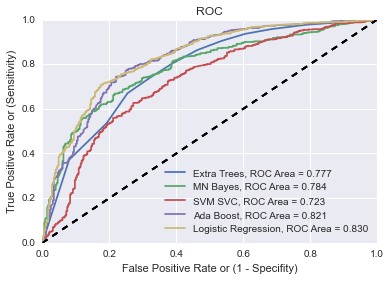

In [50]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(features, good, test_size=0.3, random_state=12)

test_classifiers(x_train, x_test, y_train, y_test, features, good)

##Let's work with the text, then vectorize the text and fit it to that.
##### Instead of using characteristics about the text as features, we're going to vectorize the text and use that as the feature set

In [51]:
%%time

## We're going to get rid of stop words and non-letters.
## We're also going to run the text through a lemmatizer, which will help narrow down the feature set.
## This will take some time.

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

stop_words = set(stopwords.words("english"))
count = 0
text_clean = text
lemm = WordNetLemmatizer()

## Before cleaning the text, we'll vectorize the uncleaned text to see how the difference it makes.
vect = CountVectorizer(decode_error = 'ignore')
vect.fit(text_clean)
dirty_text_length = len(vect.vocabulary_)

for x in range(len(text_clean)):
    count +=1
    if count % 1000 == 0:
        print "Cleaning text #{}...".format(count)
    w = text[x]
    w = re.sub("[^a-zA-Z]"," ", w)    # gets rid of non-letters and substitutes it with a space
    w = word_tokenize(w)    # Tokenizes the sentence, breaking it up into a list of words rather than one long string.
    w = [lemm.lemmatize(z) for z in w if not z in stop_words]    # deletes stop words from the text, or words that don't add any meaning
    text_clean[x] = w

text_clean = [' , '.join(z).strip() for z in text_clean]

Cleaning text #1000...
Cleaning text #2000...
Cleaning text #3000...
Wall time: 8min 43s


C:\Users\samchu\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [52]:
## Fit it to a regular count vectorizor so we can compare the unprocessed vs. processed text.

vect = CountVectorizer(decode_error = 'ignore')
vect.fit(text_clean)
clean_text_length = len(vect.vocabulary_)
print "Text without any edits had {} unique tokens.".format(dirty_text_length)
print "Text after removing stop words and lemmatizing, the text had {} unique tokens.".format(clean_text_length)

## Vectorize the text with sklearn's TfidfVectorizer... This weights each word depending on the Tf-idf importance.

vect = TfidfVectorizer(stop_words='english', ngram_range = (1,1), decode_error = 'ignore')
vect.fit(text_clean)

## Map the vectorized text to an array and Pandas dataframe

text_dtm = vect.transform(text_clean)
text_array = text_dtm.toarray()
text_df = pd.DataFrame(text_array, columns = vect.get_feature_names())

Text without any edits had 11232 unique tokens.
Text after removing stop words and lemmatizing, the text had 10159 unique tokens.


Per the above results, this performed slightly better than the model generated with the sentiment score, positive/negative ratio and length of text. Multinomial Naive Bayes performed the best so far as well.

Extra Forest score: 0.790262172285
Multinomial Naive Bayes score: 0.723782771536
SVC Score: 0.672284644195
Ada Boosted Decision Tree Score: 0.814606741573
Logistic Regression Score: 0.828651685393

Extra Forest AUC: 0.803608777336
Multinomial Naive Bayes AUC: 0.857522618363
SVC AUC: 0.881061759872
Ada Boosted Decision Tree AUC: 0.844788624324
Logistic Regression AUC: 0.887655440687


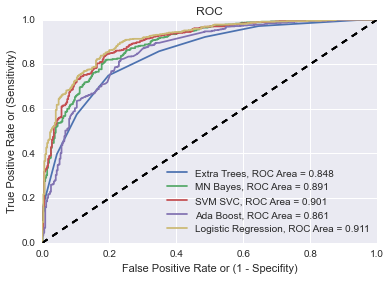

In [53]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(text_array, good, test_size=0.3, random_state=12)

test_classifiers(x_train, x_test, y_train, y_test, text_array, good)

### Next Steps: Try using a voting funciton to manually boost current models; test how an aggregate predictor works.

In [ ]:
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import LinearSVC
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.linear_model import LogisticRegression

# x_train, x_test, y_train, y_test = cross_validation.train_test_split(features, stars, test_size=0.3, random_state=12)
# extra = ExtraTreesClassifier()
# mnbayes = MultinomialNB()
# linearSVC = LinearSVC(C=1)
# adaboost = AdaBoostClassifier()
# logreg = LogisticRegression()

# ## Create a list that contains five classifiers, then fit them.
# voter = [forest, mnbayes, linearSVC, adaboost, logreg]
# for x in voter:
#     x.fit(x_train, y_train)

# number_votes = len(voter)

# ## Put the predictions of all five classifiers into another array.
# votes = []
# for x in voter:
#     votes.append(x.predict(x_test))

# ## Put all predictions into a list of votes
# all_votes = []
# for y in votes:
#     for x in y:
        